This is my handin for CSCI-2951-R Assignment 3

I've tried to leave informative comments throughout and cited any sklearn pages where I might have gotten some code snippets.  I've also placed some markdown cells throughout to help describe my train of thought.  However to summarize.  I loaded my datafiles, merged them and shaped them to be passed to machine learning algorithms.  To begin I used all 15 fields and took the mean only of 1000 records to make 1 value for each 10 second segment of time.  I did a multi-classifier and compared all five files at the same time.  All three methods I tried were very successful.

Feeling like using all 15 fields was cheating I implemented a feature selection algorithm to find the most informative features, and then tested on just those fields.  Those features didn't get me 100% accuracy.  So implemented another feature selection which highlighted some different fields that turned out to be highly accurate.

In [117]:
# Loading all of the data files, all at 100mhz or 100 samples per second
# Thanks to Katie for her files, I needed the sitting, jogging and stairs ones,
# the others are my own

import numpy as np
import csv
import itertools

# these magic rows make the long floats in a np array all output nicely for display
float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

clsTrain = [] # this is store my array of classifiers (0-4) - kinda hacky but it works
clsTest = []

#This takes in the csv files and returns an array that can be used for machine learning
#also returns the header row which is the same for all of my files
def load_files(input_file, cls_num):
    output_array = []
    input_headers = []
    with open(input_file, 'rb') as f:
        reader = csv.reader(f)
        input_headers = reader.next() #saves the headers
        for row in reader:
            output_array.append(row[1:]) # Don't need the timestamp
    
    input_headers = input_headers[1:] # again - don't need the timestamp
    # Convert to a dict to make using it easier later on
    output_headers = {}
    for i in range(len(input_headers)):
        output_headers[i] = input_headers[i]
            
    # Prior testing gave me the size of the files so I know I can skip the first 10 seconds (1000 rows)
    # and then take the next 30,000 records to get 30 - 10 second chunks
    # never forget that it's all zero indexed
    output_array = output_array[999:30999]
    
    # Now let's reduce down to 10 second chunks aka 1000 rows
    compressed = []
    n = 0
    temp = []
    
    for row in output_array:
        temp.append(row)
        n +=1
        if n == 1000: 
            temp = np.array(temp).astype(float) #convert to a numpy float array so I can do the next line
            compressed.append(temp.mean(axis=0).tolist()) #this averages by columns and makes it a list of lists
            temp = []
            n = 0
            
    # I use this to build the 'y' or classifier array for use later
    for i in range(30):
        if i < 24:
            clsTrain.append(cls_num)
        else:
            clsTest.append(cls_num)
            

    return compressed, output_headers
    
# rawWalkValues, Labels = load_files("walking2.csv",0) # my walking - which doesn't play well with Katie's movement data
rawWalkValues, Labels = load_files("Walking-katie.csv",0) # Katie's walking
rawSittingValues, Labels = load_files("sitting.csv",1)
rawCarValues, Labels = load_files("car.csv",2)
rawJogValues, Labels = load_files("Jogging.csv",3)
rawStairsValues, Labels = load_files("Steps.csv",4)

# This dictionary helps translate from an int to the type of activity downstream
dataType = {0:'Walking', 1:'Sitting', 2:'Car', 3:'Jogging', 4:'Stairs'}

# put everything together into one merged training and then seperate test sets
# first 24 records from each  train, last 6 = testing
allTrain = rawWalkValues[:24] + rawSittingValues[:24] + rawCarValues[:24] + rawJogValues[:24] + rawStairsValues[:24]
walkTest = rawWalkValues[24:] 
sitTest = rawSittingValues[24:]
carTest = rawCarValues[24:]
jogTest = rawJogValues[24:]
stairsTest = rawStairsValues[24:]
allTest = rawWalkValues[24:] + rawSittingValues[24:] + rawCarValues[24:] + rawJogValues[24:] + rawStairsValues[24:]


In [104]:
# This block is just to test my data loads and various setup stuff from the block above
# Feel free to use it to see anything in particular
# print Labels
# print rawWalkValues[0]
# print clsTrain
# print len(rawWalkValues[:24])
# print dataType[0]

#Testing the length of the arrays, I should have 30 records after chunking into 10 second sections by / 1000
# print "walk -",len(rawWalkValues)
# print "sit -",len(rawSittingValues)
# print "car -",len(rawCarValues)
# print "jog -",len(rawJogValues)
# print "stairs -",len(rawStairsValues)

So now that I've got my data loaded and in the correct format lets try some machine learning.
At this point I'm doing a multi-classifier with all five data sets combined and using all 15 data fields, more on that later

Since all of my data was 100MHZ and I had a 1000 records per 10 second chunk I only used the means of each field. I felt that with that much data it would probably work pretty good, which it does.  Instead of changing the aggregation calculation up I did some interesting ML things later on.

In [120]:
# Where the Decision Tree Learning Happens
# This is a multi-classifier for all five conditions 
from sklearn import tree
from sklearn.svm import LinearSVC

clf = tree.DecisionTreeClassifier()
  
clf = tree.DecisionTreeClassifier()
clf = clf.fit(allTrain, clsTrain)

# Full disclosure - if you run this a few times on my walking data (not Katie's) you could get different output results each time

In [121]:
# the results for the Decision Tree learning
print "Score for all test data:",clf.score(allTest, clsTest)
# In multi-label classification, this is the subset accuracy which is a harsh metric since you require for 
# each sample that each label set be correctly predicted.

# print "Score for Sit test data:",clf.score(sitTest, [1,1,1,1,1,1])

# clf.predict(walkTest) # the walkTest is interesting because it sometimes gets sitting, but mostly finds walking
clfwalkResults = clf.predict_proba(walkTest)
clfsitResults = clf.predict_proba(sitTest)
clfcarResults =  clf.predict_proba(carTest)
clfjogResults =  clf.predict_proba(jogTest)
clfstairsResults =  clf.predict_proba(stairsTest)

print "Column Data Types"
print dataType.values()
print "Walking: Score for walk test ",clf.score(walkTest, [0,0,0,0,0,0]),"\n", clfwalkResults
print "Sitting: Score for sit test ",clf.score(sitTest, [1,1,1,1,1,1]),"\n", clfsitResults
print "Car drive: Score for car test ",clf.score(carTest, [2,2,2,2,2,2]),"\n", clfcarResults
print "Jogging: Score for jog test ",clf.score(jogTest, [3,3,3,3,3,3]),"\n", clfjogResults
print "Stairs: Score for stairs test ",clf.score(stairsTest, [4,4,4,4,4,4]),"\n", clfstairsResults


Score for all test data: 0.933333333333
Column Data Types
['Walking', 'Sitting', 'Car', 'Jogging', 'Stairs']
Walking: Score for walk test  1.0 
[[1.000 0.000 0.000 0.000 0.000]
 [1.000 0.000 0.000 0.000 0.000]
 [1.000 0.000 0.000 0.000 0.000]
 [1.000 0.000 0.000 0.000 0.000]
 [1.000 0.000 0.000 0.000 0.000]
 [1.000 0.000 0.000 0.000 0.000]]
Sitting: Score for sit test  1.0 
[[0.000 1.000 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000]]
Car drive: Score for car test  1.0 
[[0.000 0.000 1.000 0.000 0.000]
 [0.000 0.000 1.000 0.000 0.000]
 [0.000 0.000 1.000 0.000 0.000]
 [0.000 0.000 1.000 0.000 0.000]
 [0.000 0.000 1.000 0.000 0.000]
 [0.000 0.000 1.000 0.000 0.000]]
Jogging: Score for jog test  0.666666666667 
[[0.000 0.000 0.000 1.000 0.000]
 [1.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 1.000 0.000]
 [0.000 0.000 0.000 1.000 0.000]
 [0.000 0.00

In [122]:
# Logistic Regression ML
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

logistic = linear_model.LogisticRegression(C=1e5)
logistic.fit(allTrain, clsTrain)
# LogisticRegression(C=100000.0, class_weight=None, dual=False,fit_intercept=True, intercept_scaling=1,
#                     penalty='l2', random_state=None, tol=0.0001)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, penalty='l2',
          random_state=None, tol=0.0001)

In [123]:
#Logistic Regression output

# logistic.predict(walkTest)
# logistic.predict(sitTest)
# logistic.predict(carTest)
# logistic.predict(jogTest)
# logistic.predict(stairsTest)
# logistic.predict_proba(stairsTest)

logwalkResults = logistic.predict_proba(walkTest)
logsitResults = logistic.predict_proba(sitTest)
logcarResults =  logistic.predict_proba(carTest)
logjogResults =  logistic.predict_proba(jogTest)
logstairsResults =  logistic.predict_proba(stairsTest)

print "Score for all test data:",logistic.score(allTest, clsTest)
# In multi-label classification, this is the subset accuracy which is a harsh metric since you require for 
# each sample that each label set be correctly predicted.

print "Column Data Types"
print dataType.values()
print "Walking: Score for walk test ",logistic.score(walkTest, [0,0,0,0,0,0]),"\n", logwalkResults
print "Sitting: Score for sit test ",logistic.score(sitTest, [1,1,1,1,1,1]),"\n", logsitResults
print "Car drive: Score for car test ",logistic.score(carTest, [2,2,2,2,2,2]),"\n", logcarResults
print "Jogging: Score for jog test ",logistic.score(jogTest, [3,3,3,3,3,3]),"\n", logjogResults
print "Stairs: Score for stairs test ",logistic.score(stairsTest, [4,4,4,4,4,4]),"\n", logstairsResults

Score for all test data: 1.0
Column Data Types
['Walking', 'Sitting', 'Car', 'Jogging', 'Stairs']
Walking: Score for walk test  1.0 
[[1.000 0.000 0.000 0.000 0.000]
 [1.000 0.000 0.000 0.000 0.000]
 [1.000 0.000 0.000 0.000 0.000]
 [1.000 0.000 0.000 0.000 0.000]
 [1.000 0.000 0.000 0.000 0.000]
 [1.000 0.000 0.000 0.000 0.000]]
Sitting: Score for sit test  1.0 
[[0.000 1.000 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000]
 [0.000 1.000 0.000 0.000 0.000]]
Car drive: Score for car test  1.0 
[[0.000 0.000 1.000 0.000 0.000]
 [0.000 0.000 1.000 0.000 0.000]
 [0.000 0.000 1.000 0.000 0.000]
 [0.000 0.000 1.000 0.000 0.000]
 [0.000 0.000 1.000 0.000 0.000]
 [0.012 0.000 0.982 0.000 0.005]]
Jogging: Score for jog test  1.0 
[[0.000 0.000 0.000 1.000 0.000]
 [0.000 0.000 0.000 1.000 0.000]
 [0.000 0.000 0.000 1.000 0.000]
 [0.000 0.000 0.000 1.000 0.000]
 [0.000 0.000 0.000 1.000 0.000]
 

In [124]:
# Machine Learning with Support Vector Machines
from sklearn import svm
svc = svm.SVC(kernel='linear')
svc.fit(allTrain, clsTrain)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [131]:
# Machine learning Output

svcwalkResults = svc.predict(walkTest)
svcsitResults = svc.predict(sitTest)
svccarResults =  svc.predict(carTest)
svcjogResults =  svc.predict(jogTest)
svcstairsResults =  svc.predict(stairsTest)

print "Score for all test data:",svc.score(allTest, clsTest)
# In multi-label classification, this is the subset accuracy which is a harsh metric since you require for 
# each sample that each label set be correctly predicted.

# print "Column Data Types"
# print dataType.values()
print "Walking: Score for walk test ",svc.score(walkTest, [0,0,0,0,0,0]),":Results ", svcwalkResults
print "Sitting: Score for sit test ",svc.score(sitTest, [1,1,1,1,1,1]),":Results ", svcsitResults
print "Car drive: Score for car test ",svc.score(carTest, [2,2,2,2,2,2]),":Results ", svccarResults
print "Jogging: Score for jog test ",svc.score(jogTest, [3,3,3,3,3,3]),":Results ", svcjogResults
print "Stairs: Score for stairs test ",svc.score(stairsTest, [4,4,4,4,4,4]),":Results ", svcstairsResults

Score for all test data: 1.0
Walking: Score for walk test  1.0 :Results  [0 0 0 0 0 0]
Sitting: Score for sit test  1.0 :Results  [1 1 1 1 1 1]
Car drive: Score for car test  1.0 :Results  [2 2 2 2 2 2]
Jogging: Score for jog test  1.0 :Results  [3 3 3 3 3 3]
Stairs: Score for stairs test  1.0 :Results  [4 4 4 4 4 4]


So as you can see my machine learning works pretty good, but at this point I'm just feeding the algorithms all 15 fields from my data set and taking the mean.  I wonder how it would change if I instead just used the most relevant fields.

To find those fields I can do one of these:<br>
1) Manually try every field in the set one at a time (or groups of N, ugh)<br>
2) Visually plot the information and look for what fields I should use<br>
3) Use Feature Selection, aka machine learning to find the most informative fields in the data<br>

1 would work but just plain feels wrong given better methods.  I did do some of 2 and mapping the lines suggested using the accelerometer data, the x and z directions mostly.

However I really wanted to put machine learning to work and do feature selection. So I started working my way through this page
http://scikit-learn.org/stable/modules/feature_selection.html and began working my way down the methods on that page.

The next few blocks cover what I found

In [303]:
# The variance threshold eliminates fields (columns) of data what have a low variance, meaning they aren't informative
# after trying I'm not a fan of this method, see comments below
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8*(1-.8)))
# print sel.fit_transform(allTrain)[0] # uncomment this to see results

# So this strips out the low variance stuff but doesn't help me identify the right features, just removes certain features
# I can do (and did) a manual compare but that just seems wrong for some reason, this ends up reducing down to just 9 columns
# out of the original 15 - adjusting the variance threshold brings this up or down

In [305]:
# chi squared feature selection - which doesn't work for negative values, boo
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# X_new = SelectKBest(chi2, k=2).fit_transform(allTrain, clsTrain)
# X_new.shape

# This doesn't work for negative values which is what I have - so this selection is out
# I could have normalized or shifted everything to be positive but other methods worked so I didn't bother

In [204]:
# This attempt uses recursive feature elimination to find the n most informative features
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html for details

from sklearn.feature_selection import RFE
from sklearn.svm import SVR

estimator = SVR(kernel="linear")
selector = RFE(estimator,2,step=1) # select the n most informative features
selector = selector.fit(allTrain, clsTrain) # the magic

print Labels.values()
print(selector.support_)
print(selector.ranking_)
print "Two Most Important Features are:"
rank = selector.ranking_
for i in range(len(rank)):
    if rank[i] == 1:
        print "   -- ",Labels[i]
        
selector = RFE(estimator,1,step=1) # select the n most informative features
selector = selector.fit(allTrain, clsTrain)
print "The Most Important Feature is:"
rank = selector.ranking_
for i in range(len(rank)):
    if rank[i] == 1:
        print "   -- ",Labels[i]
        
# A frustrating thing is that this seems to provide different answers each time you run it also
# when using my walk data it said acc_X and acc_z, now it's saying roll and rotation ??

['attitude_roll', 'attitude_pitch', 'attitude_yaw', 'rotation_rate_x', 'rotation_rate_y', 'rotation_rate_z', 'gravity_x', 'gravity_y', 'gravity_z', 'user_acc_x', 'user_acc_y', 'user_acc_z', 'magnetic_field_x', 'magnetic_field_y', 'magnetic_field_z']
[ True False False False False  True False False False False False False
 False False False]
[ 1  6  2 10  7  1 12  9  4  3  8  5 14 13 11]
Two Most Important Features are:
   --  attitude_roll
   --  rotation_rate_z
The Most Important Feature is:
   --  rotation_rate_z


When I first ran this the feature selection method matched what I expected to see, user_acc_x and user_acc_z.  However now it's telling me two entirely different fields. I tested on the top 2 and 3 fields but I have my prior results saved in the text block below also.

In [211]:
# Reducing traing down to just acc_x and acc_z

def reduceToXZ(input_array):
    output_array = []
    for i in range(len(input_array)):
        temp = []
        temp.append(input_array[i][0]) # 
#         temp.append(input_array[i][2]) # Adding this one back in makes it much better
        temp.append(input_array[i][5]) # 
        output_array.append(temp)
    
    return output_array
    
trainAxAz = reduceToXZ(allTrain)
testAxAz = reduceToXZ(allTest)
walkAxAz = reduceToXZ(walkTest)
sitAxAz = reduceToXZ(sitTest)
carAxAz = reduceToXZ(carTest)
jogAxAz = reduceToXZ(jogTest)
stairsAxAz = reduceToXZ(stairsTest)

In [212]:
#SVM on reduced elements

from sklearn import svm
svc = svm.SVC(kernel='linear')
svc.fit(trainAxAz, clsTrain)  

# Machine learning Output on the reduced data set

svcwalkResults = svc.predict(walkAxAz)
svcsitResults = svc.predict(sitAxAz)
svccarResults =  svc.predict(carAxAz)
svcjogResults =  svc.predict(jogAxAz)
svcstairsResults =  svc.predict(stairsAxAz)

print "Score for all test data:",svc.score(testAxAz, clsTest)
# In multi-label classification, this is the subset accuracy which is a harsh metric since you require for 
# each sample that each label set be correctly predicted.

# print "Column Data Types"
# print dataType.values()
print "Walking: Score for walk test ",svc.score(walkAxAz, [0,0,0,0,0,0]),":Results ", svcwalkResults
print "Sitting: Score for sit test ",svc.score(sitAxAz, [1,1,1,1,1,1]),":Results ", svcsitResults
print "Car drive: Score for car test ",svc.score(carAxAz, [2,2,2,2,2,2]),":Results ", svccarResults
print "Jogging: Score for jog test ",svc.score(jogAxAz, [3,3,3,3,3,3]),":Results ", svcjogResults
print "Stairs: Score for stairs test ",svc.score(stairsAxAz, [4,4,4,4,4,4]),":Results ", svcstairsResults

Score for all test data: 0.5
Walking: Score for walk test  0.0 :Results  [3 3 3 3 3 2]
Sitting: Score for sit test  1.0 :Results  [1 1 1 1 1 1]
Car drive: Score for car test  1.0 :Results  [2 2 2 2 2 2]
Jogging: Score for jog test  0.166666666667 :Results  [1 1 1 1 1 3]
Stairs: Score for stairs test  0.333333333333 :Results  [2 4 2 4 2 2]


So as you can see, just the means of those two features did no better than a coin flip.  The above data is for the currently suggested two highest fields, it does get up to 93% if you add the third field in.

Here are my results using just acc_x and acc_z (which had previously been suggested)
Score for all test data: 0.3 <br> 
Walking: Score for walk test  0.0 :Results  [1 2 2 2 2 2] <br> 
Sitting: Score for sit test  1.0 :Results  [1 1 1 1 1 1] <br> 
Car drive: Score for car test  0.0 :Results  [1 1 1 1 1 1] <br> 
Jogging: Score for jog test  0.5 :Results  [4 3 4 3 1 3]<br> 
Stairs: Score for stairs test  0.0 :Results  [1 1 1 1 1 1]<br> 

When I added the next highest rank field (gravity_z) it got a little better, but adding the next few didn't help
Score for all test data: 0.766666666667<br> 
Walking: Score for walk test  0.0 :Results  [4 4 4 4 4 4]<br> 
Sitting: Score for sit test  1.0 :Results  [1 1 1 1 1 1]<br> 
Car drive: Score for car test  0.833333333333 :Results  [2 2 2 2 2 1]<br> 
Jogging: Score for jog test  1.0 :Results  [3 3 3 3 3 3]<br> 
Stairs: Score for stairs test  1.0 :Results  [4 4 4 4 4 4]<br> 

So maybe my RFE wasn't the best way to look for features.  So I then tried something else


1. feature 6 :gravity_x (0.134055)
2. feature 1 :attitude_pitch (0.133301)
3. feature 13 :magnetic_field_y (0.119380)
4. feature 7 :gravity_y (0.115556)
5. feature 8 :gravity_z (0.093274)
6. feature 0 :attitude_roll (0.074118)
7. feature 12 :magnetic_field_x (0.058409)
8. feature 5 :rotation_rate_z (0.057465)
9. feature 2 :attitude_yaw (0.054389)
10. feature 14 :magnetic_field_z (0.051906)
11. feature 4 :rotation_rate_y (0.027585)
12. feature 9 :user_acc_x (0.027121)
13. feature 3 :rotation_rate_x (0.022556)
14. feature 10 :user_acc_y (0.017865)
15. feature 11 :user_acc_z (0.013021)


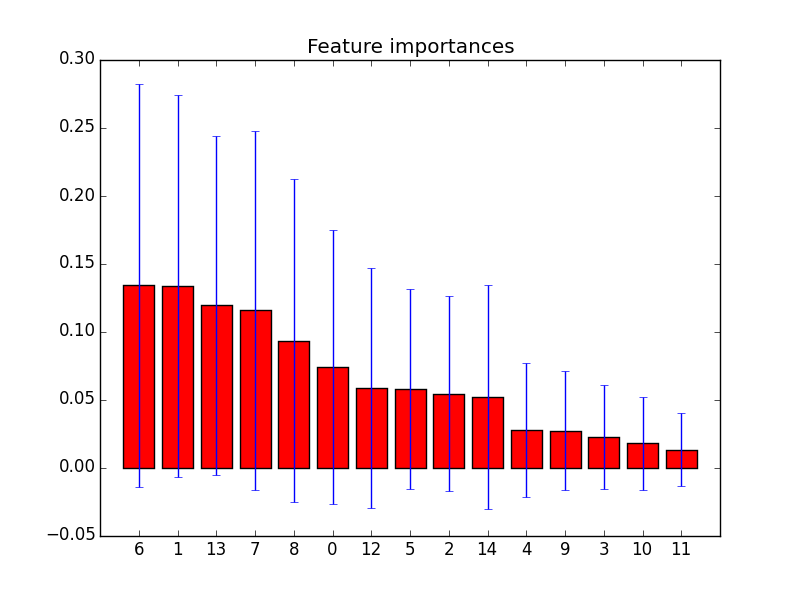

In [218]:
# This feature selection plots forest importances
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#example-ensemble-plot-forest-importances-py

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

# Comment these out to use the base example
X = np.array(allTrain)
y = clsTrain

forest.fit(X, y)

importances = forest.feature_importances_ #array with importances of each feature

idx = np.arange(0, X.shape[1]) #create an index array, with the number of features

features_to_keep = idx[importances > np.mean(importances)] #only keep features whose importance is greater than the mean importance
#should be about an array of size 3 (about)
# print features_to_keep.shape

x_feature_selected = X[:,features_to_keep] #pull X values corresponding to the most important features

# print x_feature_selected
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f],":"+ Labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# interesting enough this feature selection method doesn't fix the same fields as the RFE model
from IPython.display import Image
Image("forest_feature_selection.png")

In [240]:
# Now I'm taking the advice of my forest of trees field selection

def reduceArray(input_array):
    output_array = []
    for i in range(len(input_array)):
        temp = []
        temp.append(input_array[i][6]) # gravity_x
#         temp.append(input_array[i][1]) # attitude_roll
        temp.append(input_array[i][13]) # mag_field_y
        output_array.append(temp)
    
    return output_array
    
trainGM = reduceArray(allTrain)
testGM = reduceArray(allTest)
walkGM = reduceArray(walkTest)
sitGM = reduceArray(sitTest)
carGM = reduceArray(carTest)
jogGM = reduceArray(jogTest)
stairsGM = reduceArray(stairsTest)

In [241]:
#SVM on reduced elements

from sklearn import svm
svc = svm.SVC(kernel='linear')
svc.fit(trainGM, clsTrain)  

svcwalkResults = svc.predict(walkGM)
svcsitResults = svc.predict(sitGM)
svccarResults =  svc.predict(carGM)
svcjogResults =  svc.predict(jogGM)
svcstairsResults =  svc.predict(stairsGM)

print "Score for all test data:",svc.score(testGM, clsTest)
# In multi-label classification, this is the subset accuracy which is a harsh metric since you require for 
# each sample that each label set be correctly predicted.


# print "Column Data Types"
# print dataType.values()
print "Walking: Score for walk test ",svc.score(walkGM, [0,0,0,0,0,0]),":Results ", svcwalkResults
print "Sitting: Score for sit test ",svc.score(sitGM, [1,1,1,1,1,1]),":Results ", svcsitResults
print "Car drive: Score for car test ",svc.score(carGM, [2,2,2,2,2,2]),":Results ", svccarResults
print "Jogging: Score for jog test ",svc.score(jogGM, [3,3,3,3,3,3]),":Results ", svcjogResults
print "Stairs: Score for stairs test ",svc.score(stairsGM, [4,4,4,4,4,4]),":Results ", svcstairsResults

Score for all test data: 1.0
Walking: Score for walk test  1.0 :Results  [0 0 0 0 0 0]
Sitting: Score for sit test  1.0 :Results  [1 1 1 1 1 1]
Car drive: Score for car test  1.0 :Results  [2 2 2 2 2 2]
Jogging: Score for jog test  1.0 :Results  [3 3 3 3 3 3]
Stairs: Score for stairs test  1.0 :Results  [4 4 4 4 4 4]


Wow, so I'm able to achieve 100% accuracy by using the mean gravity_x and mag_field_y only...  I never would have found that combination on my own.  I wonder how it does using logistic regression

In [242]:
# Logistic Regression ML
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

logistic = linear_model.LogisticRegression(C=1e5)
logistic.fit(trainGM, clsTrain)

logwalkResults = logistic.predict_proba(walkGM)
logsitResults = logistic.predict_proba(sitGM)
logcarResults =  logistic.predict_proba(carGM)
logjogResults =  logistic.predict_proba(jogGM)
logstairsResults =  logistic.predict_proba(stairsGM)

print "Score for all test data:",logistic.score(testGM, clsTest)
# In multi-label classification, this is the subset accuracy which is a harsh metric since you require for 
# each sample that each label set be correctly predicted.

print "Column Data Types"
print dataType.values()
print "Walking: Score for walk test ",logistic.score(walkGM, [0,0,0,0,0,0]),"\n", logwalkResults
print "Sitting: Score for sit test ",logistic.score(sitGM, [1,1,1,1,1,1]),"\n", logsitResults
print "Car drive: Score for car test ",logistic.score(carGM, [2,2,2,2,2,2]),"\n", logcarResults
print "Jogging: Score for jog test ",logistic.score(jogGM, [3,3,3,3,3,3]),"\n", logjogResults
print "Stairs: Score for stairs test ",logistic.score(stairsGM, [4,4,4,4,4,4]),"\n", logstairsResults

Score for all test data: 0.966666666667
Column Data Types
['Walking', 'Sitting', 'Car', 'Jogging', 'Stairs']
Walking: Score for walk test  0.833333333333 
[[0.712 0.000 0.000 0.288 0.000]
 [0.727 0.000 0.000 0.273 0.000]
 [0.780 0.000 0.000 0.220 0.000]
 [0.972 0.000 0.000 0.028 0.000]
 [0.991 0.000 0.000 0.009 0.000]
 [0.365 0.000 0.000 0.635 0.000]]
Sitting: Score for sit test  1.0 
[[0.019 0.981 0.000 0.000 0.000]
 [0.019 0.981 0.000 0.000 0.000]
 [0.019 0.981 0.000 0.000 0.000]
 [0.018 0.982 0.000 0.000 0.000]
 [0.018 0.982 0.000 0.000 0.000]
 [0.018 0.982 0.000 0.000 0.000]]
Car drive: Score for car test  1.0 
[[0.009 0.000 0.986 0.005 0.000]
 [0.011 0.000 0.984 0.005 0.000]
 [0.010 0.000 0.983 0.006 0.000]
 [0.010 0.000 0.987 0.003 0.000]
 [0.009 0.000 0.987 0.004 0.000]
 [0.007 0.000 0.988 0.005 0.000]]
Jogging: Score for jog test  1.0 
[[0.437 0.000 0.000 0.563 0.000]
 [0.383 0.000 0.000 0.617 0.000]
 [0.430 0.000 0.000 0.570 0.000]
 [0.359 0.000 0.000 0.641 0.000]
 [0.433 0.00

So interestingly only those two fields are also really accurate using Logistic Regression, except for Jogging and walking.  For those two it is less than 100% certain.

One final comment.  When I used my walking file, which was the only file different from what I'm doing currently, I would get different results from the feature selection, and from some of the ML algorithms.  It seems to me that to generalize from one person's data out to a generic persons would be a very difficult task.
